In [1]:

# Script that computes correlations in activation between munsells, dissimilarity matrices and computes MDS

import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import re
import os
from scipy.spatial.transform import Rotation as R
import pandas as pd


import sys
sys.path.append('../../')

from color_scripts import color_transforms as CT # scripts with a bunch of functions for color transformations
from error_measures_scripts import Error_measures as EM
from display_scripts import display as dis
from utils_scripts import algos

from scipy.spatial import procrustes

# Ignore warnings
import warnings

In [2]:

# In[9]: path to files

txt_dir_path = '../../txt_files/'
npy_dir_path = '../../npy_files/'
pickles_dir_path = '../pickles/'
figures_dir_path = '../figures/'


root_dir = '../../'


In [3]:

# In[9]: Function
def LMS2Opp(x):
	M = np.array([[ 0.67,  1.0,  0.5],[ 0.67,  -1,  0.5],[0.67,  0,  -1]])
	return np.dot(x,M)

def load_layer(path):
	import glob
	addrs = sorted(glob.glob(path + '/*.pickle'))
	LAYER = list()
	for addr in addrs:
		pickle_in = open(addr,'rb')
		layer = pickle.load(pickle_in)
		pickle_in.close()
		LAYER.extend(layer)
	return np.array(LAYER)
#compute_and_display_MDS(layer)

def affine_transform(X, Y):
    # Normalize coordinates
    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centered Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY
    #import pdb; pdb.set_trace()
    # Compute the affine transformation using homogenous coordinates
    hom_X0 = np.vstack([X0.T, np.ones(len(X0))]).T
    hom_Y0 = np.vstack([Y0.T, np.ones(len(Y0))]).T
    
    affine_mat, R, rank, S = np.linalg.lstsq(hom_X0, hom_Y0, rcond=None)
    
    
    return affine_mat, R, S


def apply_affine_transform(affine_mat, pts):
    hom_pts = np.vstack([pts.T, np.ones(len(pts))]).T
    #import pdb; pdb.set_trace()
    tmp = np.dot(hom_pts, affine_mat)
    #out_pts = np.array([x[:-1] / x[-1] for x in tmp.T])
    
    return tmp

def compute_and_display_MDS(layer,save_path, correlation = True):
	'''
	Function that compute a similarity analysis on the activations of a given DNN layer
	'''
    
	if correlation == True:
		corr_layer = algos.correlations_layers(layer)
	#import pdb; pdb.set_trace()

		DM_layer = 1 - np.mean(corr_layer,axis = 0)
	
		DM_layer_all = 1 - corr_layer
        
	else:
		DM_layer_all = algos.similarity_layers(layer)
		DM_layer = np.mean(DM_layer_all, axis = 0)
		#DM_layer = DM_layer_all[0]

	RESULTlayer, stress_layer = algos.MDS(DM_layer)
	coeff,score,latent,explained = algos.princomp(RESULTlayer)
	#import pdb; pdb.set_trace()
	
	RESULTLAYER = [algos.MDS(DM_layer_all[i])[0] for i in range(len(DM_layer_all))]
	EXPLAINED = [algos.princomp(result)[-1] for result in RESULTLAYER]

	dis.scatter_MDS_vert(RESULTlayer[:,:4],' ', save_path + '3D.png',save_path +'2D.png',RGB_muns)
	return RESULTlayer, stress_layer, explained, score, RESULTLAYER, EXPLAINED

# In[9]: LOAD ACTIVATIONS color constant



WCS_LAB = np.load(npy_dir_path + 'WCS_LAB.npy') # Used for procrustes analysis
RGB_muns = np.load(npy_dir_path + 'RGB_WCS.npy') # Used for display
inds_330 = np.load(npy_dir_path + 'WCS_muns_index.npy') # index of the 330 WCS muns amoung 1600

WCS_MUNS_XYValue_coord = np.load(npy_dir_path + 'MUNSELL_COORDINATES.npy') # Used for procrustes analysis
#dis.scatter_MDS2(WCS_MUNS_XYValue_coord.T,'','figures/procrustes/WCS_Muns_Coor_3D.png','figures/procrustes/WCS_Muns_Coor_2D.png', RGB_muns)




def extract_procrustes( ref_coord, result_MDS, ismean = True):
        if ismean:
                disp_layer, score_procrustes, tform_procrustes = algos.procrustes( ref_coord, result_MDS[:,:3] )
                return disp_layer, tform_procrustes
        else:
                DISPLAY, TFORM = list(),list()
                for i in range(len(result_MDS)):
                        disp_layer, score_procrustes, tform_procrustes = algos.procrustes( ref_coord, result_MDS[i][:,:3] )
                        _, m2, disp_layer = procrustes(ref_coord, result_MDS[i][:,:3])
                        DISPLAY.append(100*(1 - disp_layer)), TFORM.append(tform_procrustes)
                return DISPLAY, TFORM

def extract_affine(  result_MDS, ref_coord, ismean = True):
        if ismean:
                affine_mat, residuals, S = affine_transform( result_MDS[:,:3], ref_coord.T )
                return residuals.sum()
        else:
                RESIDUALS = list()
                for i in range(len(result_MDS)):
                        affine_mat, residuals, S = affine_transform( result_MDS[i][:,:3], ref_coord.T )
                        RESIDUALS.append(residuals.sum())
                return RESIDUALS



In [10]:


MUNSELLS_LMS = np.load(npy_dir_path + 'MUNSELLS_LMS.npy')
MUNSELLS_LGN = LMS2Opp(MUNSELLS_LMS-MUNSELLS_LMS.mean(axis = 0))

conditions = ['normal','no_patch', 'wrong_illu', 'no_back', 'D65']

net_name = 'ResCC'

# Note that ConvCC is DeepCC

if net_name == 'ConvCC':
        nb_models = 10
        list_activation_path = '/home/alban/mnt/awesome/alban/works/color_constancy/All_muns/scripts_server/layers/all/'
        activations_name = '%s_Original_CC_5illu_WCS_%s.npy'
        layers = ['fc2','fc1', 'conv3', 'conv2', 'conv1']

elif net_name == 'ResCC':
        nb_models = 6
        list_activation_path = '/home/alban/mnt/awesome/alban/works/color_constancy/All_muns/scripts_server/outs/'
        activations_name = 'out_%s_RefResNet_CC_5illu_WCS_%s.npy'
        layers = ['layer3','layer2', 'layer1']




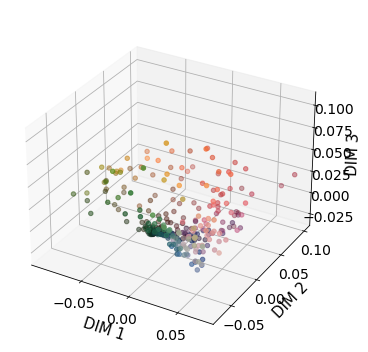

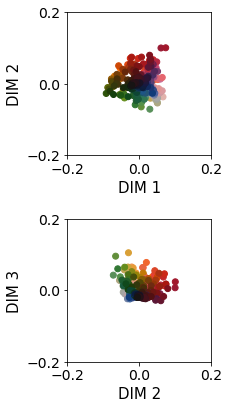

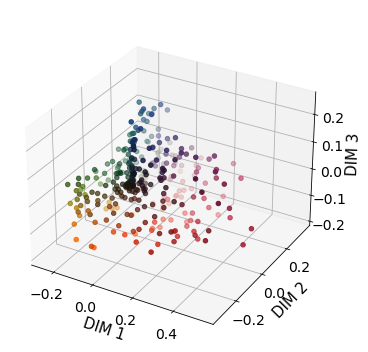

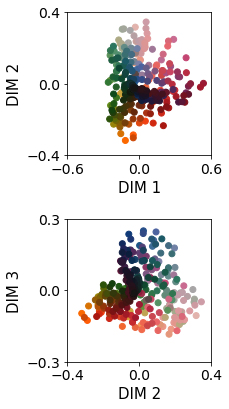

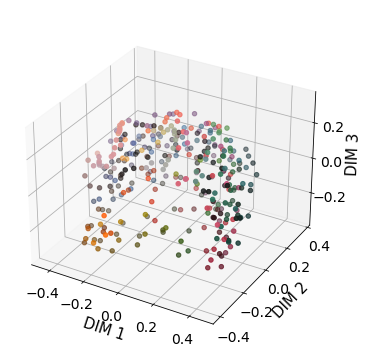

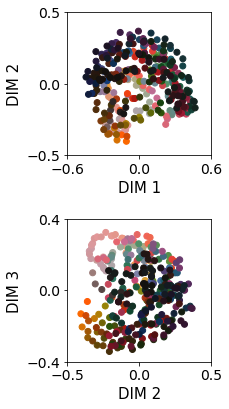

TypeError: array() takes from 1 to 2 positional arguments but 5 were given

In [11]:


EXPLAINED = {}
PROCRUSTES_LAB = {}
PROCRUSTES_LGN = {}
PROCRUSTES_LMS = {}
PROCRUSTES_MUNS = {}
AFFINE_LMS = {}
AFFINE_LAB = {}
AFFINE_MUNS = {}
TRANSFO_LAB = {}
for layer in layers[::-1]:
    PROCRUSTES_LAB[layer] = {}
    PROCRUSTES_LGN[layer] = {}
    PROCRUSTES_LMS[layer] = {}
    PROCRUSTES_MUNS[layer] = {}
    EXPLAINED[layer] = {}
    AFFINE_LMS[layer] = {}
    AFFINE_MUNS[layer] = {}
    AFFINE_LAB[layer] = {}
    TRANSFO_LAB[layer] = {}
    for condition in conditions[:1]:
        
        activations = np.load(list_activation_path + activations_name %(layer, condition))
        
        #activations = activations.mean(axis=(-3,-2))
        
        num_samples = 25
        #f_size = np.array(activations.shape[1:])
        input_to_mds = activations.reshape(nb_models, 330,num_samples,-1)
        
        
        result_MDS, stress, explained, score_MDS, RESULTALL_MDS, EXPLAINEDALL = compute_and_display_MDS(
            input_to_mds, figures_dir_path +'MDS/'+layer + '_' + net_name +'_' + condition, 
                                correlation = True)
        
        _,TRANSFO_LAB[layer][condition] = extract_procrustes( WCS_LAB.T, result_MDS[:,:3] )
        PROCRUSTES_LAB[layer][condition],_ = extract_procrustes( WCS_LAB.T, RESULTALL_MDS, ismean = False )
        
        AFFINE_LAB[layer][condition] = extract_affine( RESULTALL_MDS, WCS_LAB ,ismean = False)
        #dis.scatter_MDS2(apply_affine_transform( affine_mat_LAB, result_MDS[:,:3]),'',figures_dir_path +'/affine/'+layer +'_' + condition + '_LAB_3D.png',figures_dir_path +'affine/'+layer +'_' + condition + '_LAB_2D.png', RGB_muns, display = False)
        
        PROCRUSTES_LGN[layer][condition] = extract_procrustes( MUNSELLS_LGN[algos.compute_WCS_Munsells_categories()], RESULTALL_MDS, ismean = False )[0]
        
        PROCRUSTES_LMS[layer][condition] = extract_procrustes( MUNSELLS_LMS[algos.compute_WCS_Munsells_categories()],RESULTALL_MDS, ismean = False )[0]
        
        PROCRUSTES_MUNS[layer][condition] = extract_procrustes( WCS_MUNS_XYValue_coord.T, RESULTALL_MDS,ismean = False )[0]
        
        AFFINE_LMS[layer][condition] = extract_affine( RESULTALL_MDS, MUNSELLS_LMS[algos.compute_WCS_Munsells_categories()].T ,ismean = False)
        
        AFFINE_MUNS[layer][condition] = extract_affine( RESULTALL_MDS, WCS_MUNS_XYValue_coord ,ismean = False)
        
        EXPLAINED[layer][condition] = explained[:4]
#return EXPLAINED, EXPLAINEDALL, PROCRUSTES_LAB, PROCRUSTES_LGN, PROCRUSTES_LMS, PROCRUSTES_MUNS, AFFINE_LMS , AFFINE_LAB , AFFINE_MUNS ,TRANSFO_LAB 



#EXPLAINED, EXPLAINEDALL, PROCRUSTES_LAB, PROCRUSTES_LGN, PROCRUSTES_LMS, PROCRUSTES_MUNS, AFFINE_LMS , AFFINE_LAB , AFFINE_MUNS, TRANSFO_LAB = main()

#print('The best fit was obtained for layer %i with a value of %d' %([PROCRUSTES_MUNS[layer]['normal'] for layer in layers[::-1]]))

if net_name == 'ConvCC':
    R2_ConvCC = [np.array(PROCRUSTES_LAB[layer]['normal']).mean() for layer in layers[::-1]]
    R2_ConvCC_LMS = [np.array(PROCRUSTES_LMS[layer]['normal']).mean() for layer in layers[::-1]]
    R2std_ConvCC = [np.array(PROCRUSTES_LAB[layer]['normal']).std() for layer in layers[::-1]]
    R2std_ConvCC_LMS = [np.array(PROCRUSTES_LMS[layer]['normal']).std() for layer in layers[::-1]]
    R2_ResCC = np.array([38.20314214034651, 43.797811978255346, 13.006203324216981]) # Values found for ResNet with this scripts
    R2std_ResCC = np.array([6.247546173957506, 5.089866676228974, 2.251469436738358])
    R2_ResCC_LMS = np.array([38.849548124478474, 47.83074895968806, 14.523794183264132]) # Values found for ResNet with this scripts
    R2std_ResCC_LMS = np.array([3.5254157890188083, 4.993156852806843, 6.469711190442599])
else:
    R2_ConvCC = np.array([66.41759441306412, 68.38395515569066, 77.07064225894631, 88.24782239278332, 71.28941056240583]) # Values found for DeepCC with this algo
    R2std_ConvCC = np.array(6.308441736840685, 4.482985829585884, 3.2047531799331463, 2.5976015170400473, 7.444809053015025)
    R2_ConvCC_LMS = np.array([68.11046497246218, 63.592152178232354, 58.8384875389033, 53.332050719713585, 45.973039386243116]) # Values found for DeepCC with this algo
    R2std_ConvCC_LMS = np.array([2.3543561573345517, 4.845150131181346, 4.557406523175423, 6.737304728062783, 2.697759609237931])
    R2_ResCC = [np.array(PROCRUSTES_LAB[layer]['normal']).mean() for layer in layers[::-1]]
    R2std_ResCC = [np.array(PROCRUSTES_LAB[layer]['normal']).std() for layer in layers[::-1]]
    R2_ResCC_LMS = [np.array(PROCRUSTES_LMS[layer]['normal']).mean() for layer in layers[::-1]]
    R2std_ResCC_LMS = [np.array(PROCRUSTES_LMS[layer]['normal']).std() for layer in layers[::-1]]


In [12]:
print([np.array(EXPLAINED[layer]['normal'])[:-1].sum() for layer in layers[::-1]])
print(EXPLAINED[layer]['normal'])

[77.89387878582033, 84.00107595591959, 43.73736359357754]
[21.09935642 11.73369005 10.90431713 10.13688387]


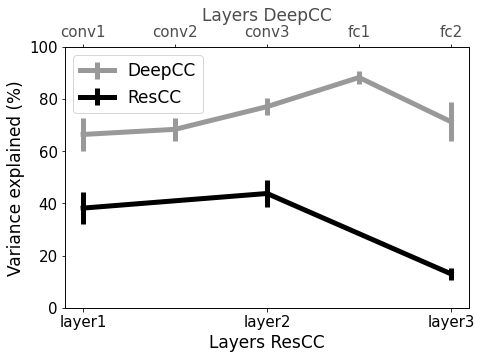

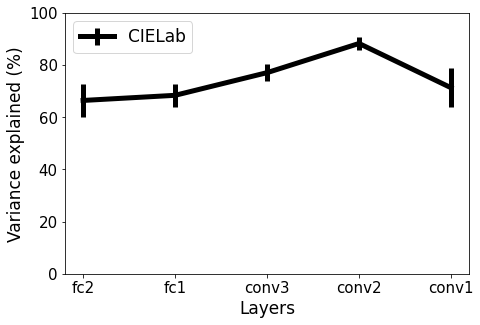

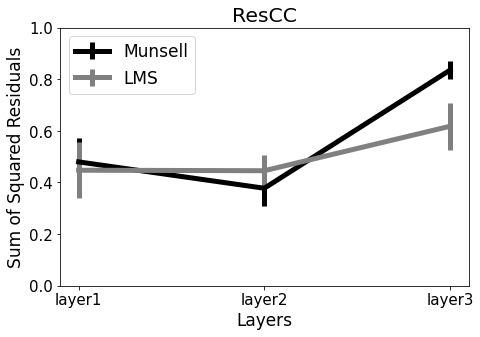

In [16]:


dis.DEFINE_PLT_RC(type = 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1.errorbar(range(1,6),R2_ConvCC_LMS,yerr=R2std_ConvCC_LMS,color = [0.65,0.35,0.35], label = 'LMS')
ax1.errorbar(range(1,6), R2_ConvCC, yerr=R2std_ConvCC, color = [0.6, 0.6, 0.6], label = 'DeepCC')
#ax1.errorbar(range(1,6,2),R2_ResCC_LMS,yerr=R2std_ResCC_LMS,color = 'r', label = 'LMS')
ax1.errorbar(range(1,6,2), R2_ResCC, yerr=R2std_ResCC, color = 'black', label = 'ResCC')
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax1.set_xticks([1,3,5])
ax1.set_xticklabels(['layer1', 'layer2', 'layer3'])
ax1.set_xlabel('Layers ResCC')
ax2.set_xticks(range(1,6))
ax2.set_xticklabels(['conv1', 'conv2', 'conv3', 'fc1', 'fc2'], color = [0.3, 0.3, 0.3])
ax2.set_xlabel('Layers DeepCC', color = [0.3, 0.3, 0.3])
ax1.set_ylabel('Variance explained (%)')
ax1.set_ylim(0,100)
#plt.title(net_name)
#plt.ylim(0,0.4)
#ax1.set_yticks(np.arange(0,0.41,0.2))
#ax1.set_ylabel('Median CCI')
ax1.legend()
fig.subplots_adjust(top=0.865,bottom=0.14,left=0.149,right=0.952,hspace=0.2,wspace=0.2)
fig.savefig(figures_dir_path + 'allmodels_procrustes.png', dpi=400)
plt.show()

dis.DEFINE_PLT_RC(type = 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1.errorbar(range(1,6),R2_ConvCC_LMS,yerr=R2std_ConvCC_LMS, color = 'r', label = 'LMS')
ax1.errorbar(range(1,6), R2_ConvCC, yerr=R2std_ConvCC, color = 'k', label = 'CIELab')
ax1.set_xticks(range(1,6))
ax1.set_xticklabels(['fc2','fc1', 'conv3', 'conv2', 'conv1'])
ax1.set_xlabel('Layers')
ax1.set_ylabel('Variance explained (%)')
ax1.set_ylim(0,100)
ax1.legend()
fig.subplots_adjust(top=0.865,bottom=0.14,left=0.149,right=0.952,hspace=0.2,wspace=0.2)
fig.savefig(figures_dir_path +net_name + '_procrustes.png', dpi=400)
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.errorbar(range(1,len(layers)+1), [np.array(AFFINE_MUNS[layer]['normal']).mean() for layer in layers[::-1]], 
             yerr = [np.array(AFFINE_MUNS[layer]['normal']).std() for layer in layers[::-1]],color = 'k', label = 'Munsell')
ax1.errorbar(range(1,len(layers)+1), [np.array(AFFINE_LMS[layer]['normal']).mean() for layer in layers[::-1]], 
             yerr = [np.array(AFFINE_LMS[layer]['normal']).std() for layer in layers[::-1]], color = [0.5,0.5,0.5], label = 'LMS')
ax1.set_xticks(range(1,len(layers)+1))
ax1.set_xticklabels(layers[::-1])
plt.ylim(0,1)
plt.xlabel('Layers')
plt.ylabel('Sum of Squared Residuals')
plt.title(net_name)
#plt.xlim(-1,40)
#ax1.set_ylabel('Median CCI')
plt.legend()
fig.tight_layout()
fig.savefig(figures_dir_path +net_name + '_affine.png', dpi=400)
plt.show()




In [15]:
print(R2_ResCC)
print(R2std_ResCC)
print(R2_ResCC_LMS)
print(R2std_ResCC_LMS)
print(R2_ConvCC)
print(R2std_ConvCC)
print(R2_ConvCC_LMS)
print(R2std_ConvCC_LMS)

[38.20314214 43.79781198 13.00620332]
[6.24754617 5.08986668 2.25146944]
[38.84954812 47.83074896 14.52379418]
[3.52541579 4.99315685 6.46971119]
[66.41759441 68.38395516 77.07064226 88.24782239 71.28941056]
[6.308441736840685, 4.482985829585884, 3.2047531799331463, 2.5976015170400473, 7.444809053015025]
[38.11726500719739, 63.064716870177804, 57.58926843408953, 38.79928175242083, 31.79914656486601]
[6.854465114094547, 3.9070437998692253, 6.173704046525675, 3.8465598862502777, 7.946388411754636]


In [72]:


for i in [TRANSFO_LAB[layer]['normal'] for layer in layers[::-1]]:
        #print(np.round(i['rotation'],2))
        M = np.round(i['rotation'],2)
        
        Mr = R.from_matrix(M.T).as_euler('xyz', degrees = True)
        print(Mr.astype(int))
        
        permutation = np.argmax(np.absolute(M), axis = 0)
        idx = np.empty_like(permutation)
        idx[permutation] = np.arange(len(permutation))
        
        M_pos = M[:,idx]
        M_neg = -M[:,idx]
        Mr_pos = R.from_matrix(M_pos.T).as_euler('xyz', degrees = True)
        Mr_neg = R.from_matrix(M_neg.T).as_euler('xyz', degrees = True)
        print(Mr_pos.astype(int), Mr_neg.astype(int))
        print(np.absolute(Mr_pos).sum().astype(int), np.absolute(Mr_neg).sum().astype(int))

np.save('inner_rep_%s.npy'%net_name, [EXPLAINED, PROCRUSTES_LAB, PROCRUSTES_LGN, PROCRUSTES_LMS, PROCRUSTES_MUNS, AFFINE_LMS , AFFINE_LAB , AFFINE_MUNS, TRANSFO_LAB])


temp_explained = {}
for layer in layers[::-1]:
        temp_explained[layer] = {}
        for condition in conditions[:1]:
                temp_explained[layer][condition] = EXPLAINED[layer][condition].sum()

df = pd.DataFrame(temp_explained)


[134   4  -5]
[ 36 -42 -17] [  30   32 -173]
96 236
[-16  -1  -6]
[-16  -1  -6] [180   1 180]
25 361
[  0  -4 -10]
[  0  -4 -10] [177   0   0]
15 177
[ -1  -2 177]
[  -6  -18 -162] [173  -1 178]
187 353
[-54  51   5]
[ 0  6 -1] [-148   -5 -173]
8 327
